# TITLE: Car Price Prediction Using Machine Learning:

`Author:` [Muhammad Umar Farooqi](https://github.com/umarii04)\
`Date:` 4th.Sep.2025



<h2 style="background-color:#228B22; color:white; padding:10px 20px; border-radius:8px; font-weight:bold; font-family:'Trebuchet MS', sans-serif; display:inline-block;">
Importing the libraries:
</h2>



In [46]:
import os, re, joblib, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
sns.set_theme()
RANDOM_STATE = 42
SNAPSHOT_YEAR = 2025   # Age = SNAPSHOT_YEAR - Year



<h2 style="background-color:#228B22; color:white; padding:10px 20px; border-radius:8px; font-weight:bold; font-family:'Trebuchet MS', sans-serif; display:inline-block;">
Load the dataset:
</h2>



In [11]:
df = pd.read_csv("car data.csv")
df.head()


,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


<h2 style="background-color:#228B22; color:white; padding:10px 20px; border-radius:8px; font-weight:bold; font-family:'Trebuchet MS', sans-serif; display:inline-block;">
Exploratory Data Analysis(EDA):
</h2>



In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [ ]:
print(df.shape)

(301, 9)


In [14]:
df.describe()

,Year,Selling_Price,Present_Price,Driven_kms,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.642584,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [ ]:
df.isnull().sum()
# no null values in the dataset

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Driven_kms       0
Fuel_Type        0
Selling_type     0
Transmission     0
Owner            0
dtype: int64

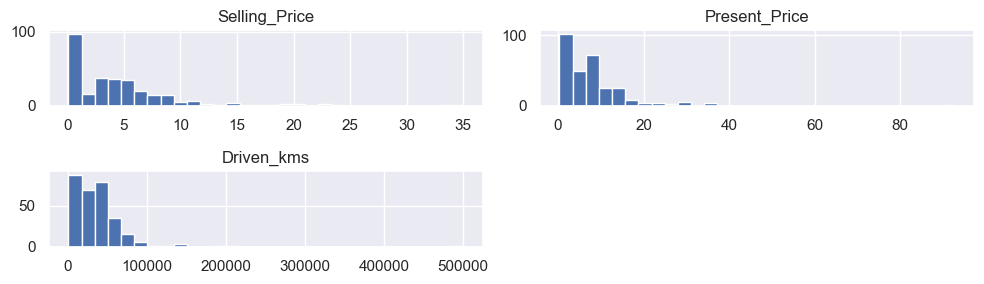

In [19]:
num_cols_raw = ["Selling_Price", "Present_Price", "Driven_kms"]
df[num_cols_raw].hist(bins=30, figsize=(10,3))
plt.tight_layout(); plt.show()

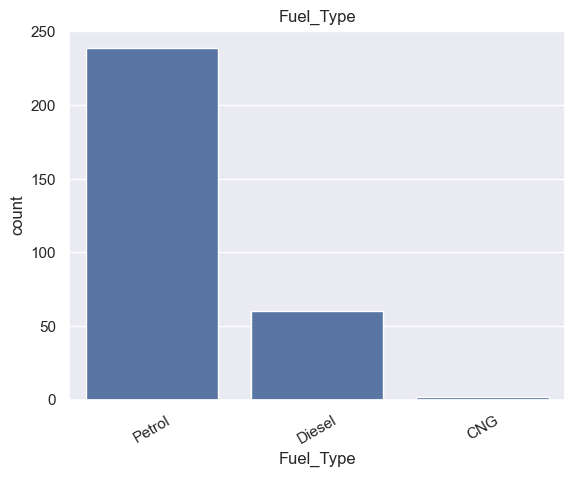

In [21]:
for c in ["Fuel_Type"]:
    plt.figure()
    sns.countplot(x=c, data=df, order=df[c].value_counts().index)
    plt.title(c); plt.xticks(rotation=30); plt.show()

<Axes: xlabel='Fuel_Type', ylabel='count'>

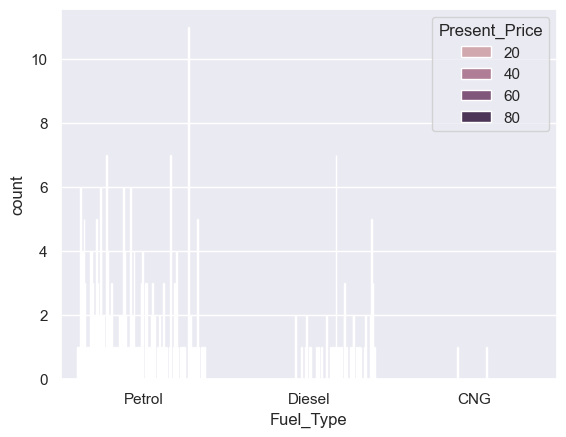

In [28]:
sns.countplot(data=df , x="Fuel_Type", hue= 'Present_Price')

<h2 style="background-color:#228B22; color:white; padding:10px 20px; border-radius:8px; font-weight:bold; font-family:'Trebuchet MS', sans-serif; display:inline-block;">
Feature Engineering:
</h2>



In [37]:
def extract_brand(name: str) -> str:
    if pd.isna(name): 
        return "other"
    brand = name.split()[0].lower()
    brand = re.sub(r"[^a-z0-9]", "", brand)
    return brand or "other"

def add_features(df_in: pd.DataFrame, snapshot_year: int = SNAPSHOT_YEAR) -> pd.DataFrame:
    df2 = df_in.copy()

    # Brand from Car_Name
    df2["Brand"] = df2["Car_Name"].astype(str).map(extract_brand)
    counts = df2["Brand"].value_counts()
    rare_brands = counts[counts < 5].index
    df2.loc[df2["Brand"].isin(rare_brands), "Brand"] = "other"

    # Car age
    df2["Age"] = (snapshot_year - df2["Year"]).clip(lower=0)

    # Log transform for kms
    df2["Driven_kms_log"] = np.log1p(df2["Driven_kms"])

    # Helper ratio
    df2["price_per_age"] = df2["Present_Price"] / (df2["Age"] + 1)

    # Drop high-cardinality/raw cols not needed after FE
    df2 = df2.drop(columns=["Car_Name", "Year"])
    return df2

df_fe = add_features(df)
df_fe.head()


,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,Brand,Age,Driven_kms_log,price_per_age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,other,11,10.203629,0.465833
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,sx4,12,10.668979,0.733846
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,ciaz,8,8.839422,1.094444
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,other,14,8.556606,0.276667
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,swift,11,10.656106,0.572500


<h2 style="background-color:#228B22; color:white; padding:10px 20px; border-radius:8px; font-weight:bold; font-family:'Trebuchet MS', sans-serif; display:inline-block;">
Train and Test Split:
</h2>



In [42]:
# Cell 6
TARGET = "Selling_Price"
X = df_fe.drop(columns=[TARGET])
y = df_fe[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((240, 10), (61, 10))

<h2 style="background-color:#228B22; color:white; padding:10px 20px; border-radius:8px; font-weight:bold; font-family:'Trebuchet MS', sans-serif; display:inline-block;">
Pre-Processing:
</h2>



In [43]:
# Cell 7
num_cols = ["Present_Price","Driven_kms","Driven_kms_log","Owner","Age","price_per_age"]
cat_cols = ["Fuel_Type","Selling_type","Transmission","Brand"]

numeric_tf = Pipeline([("scaler", StandardScaler())])
# Note: If your sklearn is old and errors on min_frequency, remove that arg.
categorical_tf = Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=5))])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ],
    remainder="drop"
)


<h2 style="background-color:#228B22; color:white; padding:10px 20px; border-radius:8px; font-weight:bold; font-family:'Trebuchet MS', sans-serif; display:inline-block;">
Baseline model: ElasticNet
</h2>



In [ ]:
enet = Pipeline([
    ("pre", preprocess),
    ("model", ElasticNet(max_iter=2000, random_state=RANDOM_STATE))
])

enet_params = {
    "model__alpha": [0.01, 0.1, 1, 10],
    "model__l1_ratio": [0.1, 0.5, 0.9],
}

enet_grid = GridSearchCV(
    enet, enet_params,
    cv=5, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=0
)
enet_grid.fit(X_train, y_train)

print("ElasticNet best CV RMSE:", -enet_grid.best_score_)
print("ElasticNet best params:", enet_grid.best_params_)


ElasticNet best CV RMSE: 0.8240031434114303
ElasticNet best params: {'model__alpha': 0.01, 'model__l1_ratio': 0.9}


<h2 style="background-color:#228B22; color:white; padding:10px 20px; border-radius:8px; font-weight:bold; font-family:'Trebuchet MS', sans-serif; display:inline-block;">
RandomForest
</h2>



In [45]:
rf = Pipeline([
    ("pre", preprocess),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE))
])

rf_params = {
    "model__n_estimators": [400, 800],
    "model__max_depth": [None, 8, 12],
    "model__min_samples_leaf": [1, 3, 5],
}

rf_grid = GridSearchCV(
    rf, rf_params,
    cv=5, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=0
)
rf_grid.fit(X_train, y_train)

print("RF best CV RMSE:", -rf_grid.best_score_)
print("RF best params:", rf_grid.best_params_)


RF best CV RMSE: 1.302111575002654
RF best params: {'model__max_depth': 12, 'model__min_samples_leaf': 1, 'model__n_estimators': 800}


<h2 style="background-color:#228B22; color:white; padding:10px 20px; border-radius:8px; font-weight:bold; font-family:'Trebuchet MS', sans-serif; display:inline-block;">
Linear Regression
</h2>



In [48]:
lr = Pipeline([
    ("pre", preprocess),
    ("model", LinearRegression())
])
lr_params = {}
lr_grid = GridSearchCV(
    lr, lr_params,
    cv=5, n_jobs=-1, scoring="neg_root_mean_squared_error", verbose=0
)
lr_grid.fit(X_train, y_train)

print("Linear Regression best CV RMSE:", -lr_grid.best_score_)


Linear Regression best CV RMSE: 1.059298315717659


<h2 style="background-color:#228B22; color:white; padding:10px 20px; border-radius:8px; font-weight:bold; font-family:'Trebuchet MS', sans-serif; display:inline-block;">
Compare CV scores & pick the winner
</h2>



In [49]:
# Cell 11
candidates = [
    ("ElasticNet", enet_grid),
    ("RandomForest", rf_grid),
    ("LinearRegression", lr_grid),
]
best_name, best_grid = sorted(candidates, key=lambda kv: -kv[1].best_score_)[0]

print("Best by CV:", best_name)
print("Best CV RMSE:", -best_grid.best_score_)
print("Params:", best_grid.best_params_)


Best by CV: ElasticNet
Best CV RMSE: 0.8240031434114303
Params: {'model__alpha': 0.01, 'model__l1_ratio': 0.9}


<h2 style="background-color:#228B22; color:white; padding:10px 20px; border-radius:8px; font-weight:bold; font-family:'Trebuchet MS', sans-serif; display:inline-block;">
Evaluate of Metrics
</h2>



In [52]:
y_pred = best_grid.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print(f"TEST → MAE: {mae:.3f} | R²: {r2:.3f}")


TEST → MAE: 0.508 | R²: 0.976


<h2 style="background-color:#228B22; color:white; padding:10px 20px; border-radius:8px; font-weight:bold; font-family:'Trebuchet MS', sans-serif; display:inline-block;">
Actual vs Predicted:
</h2>



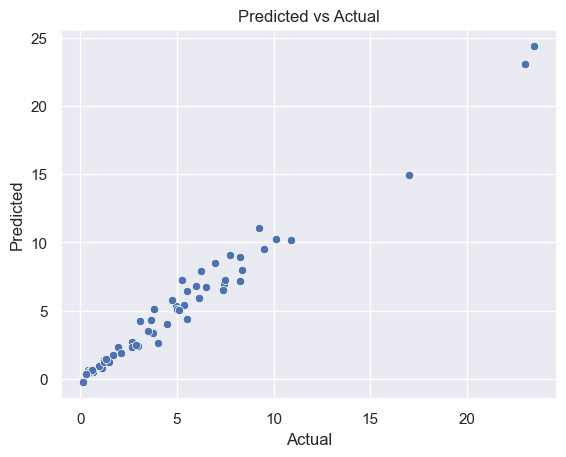

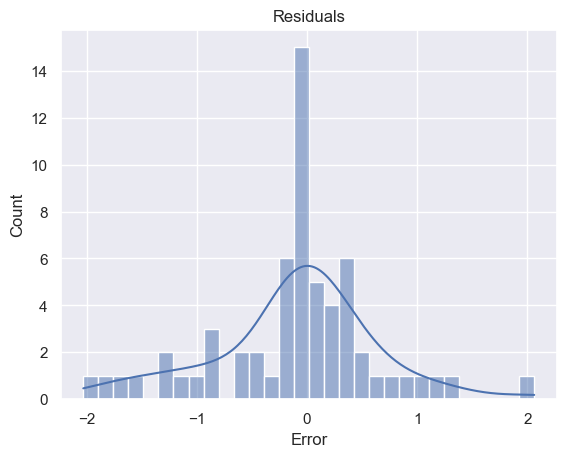

In [53]:
plt.figure()
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("Predicted vs Actual"); plt.show()

residuals = y_test - y_pred
plt.figure()
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals"); plt.xlabel("Error"); plt.show()


In [55]:
MODEL_PATH = "car_price_pipeline_model.joblib"
joblib.dump(best_grid, MODEL_PATH)
MODEL_PATH

'car_price_pipeline_model.joblib'

In [60]:
def predict_price(example: dict, snapshot_year: int = SNAPSHOT_YEAR, model_path: str = "car_price_pipeline_model.joblib") -> float:
    pipe = joblib.load(model_path)
    df_one = pd.DataFrame([example])
    df_one_fe = add_features(df_one, snapshot_year=snapshot_year)
    return float(pipe.predict(df_one_fe)[0])

# Example usage:
example = {
    "Car_Name": "swift vxi",
    "Year": 2016,
    "Selling_Price": 0,      # not used
    "Present_Price": 6.0,
    "Driven_kms": 42000,
    "Fuel_Type": "Petrol",
    "Selling_type": "Dealer",
    "Transmission": "Manual",
    "Owner": 1
}
print("Predicted price:", predict_price(example))


Predicted price: 4.182261102157447
